In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as clr
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('./aux-files/hard-data.csv')

# convert the data to numpy arrays
X = df[['x_1', 'x_2']].to_numpy()
y = df['y'].to_numpy()

# scale the input data
ss = StandardScaler()
X = ss.fit_transform(X=X)

# replaced the columns of the dataframe with the transformed data
df['x_1'] = X[:, 0]
df['x_2'] = X[:, 1]

In [194]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# convert the data to torch tensors
X = torch.tensor(data=X, dtype=torch.float32)
y = torch.tensor(data=y, dtype=torch.float32)

# define the neural network model architecture
torch.manual_seed(42)
k1 = 8 # width of first hidden layer
k2 = 8 # width of second hidden layer
k3 = 4 # width of third hidden layer

class NeuralNetwork(nn.Module):
    def __init__(self, input_dimension):
        super().__init__()

        # three hidden layers...
        self.hidden1_linear = nn.Linear(in_features=input_dimension, out_features=k1)
        self.hidden1_act = nn.ReLU()
        self.hidden2_linear = nn.Linear(in_features=k1, out_features=k2)
        self.hidden2_act = nn.ReLU()
        self.hidden3_linear = nn.Linear(in_features=k2, out_features=k3)
        self.hidden3_act = nn.ReLU()
        
        # ...and one output layer
        self.output_linear = nn.Linear(in_features=k3, out_features=1)
        self.output_act = nn.Sigmoid()

    def forward(self, X):
        X = self.hidden1_act(self.hidden1_linear(X))
        hidden_output_1 = X
        X = self.hidden2_act(self.hidden2_linear(X))
        hidden_output_2 = X
        X = self.hidden3_act(self.hidden3_linear(X))
        hidden_output_3 = X
        X = self.output_act(self.output_linear(X))

        return X, hidden_output_1, hidden_output_2, hidden_output_3
    
model = NeuralNetwork(input_dimension=2)

parameters = {}
for name, parameter in model.named_parameters():
    parameters = parameters | {name: parameter.T.detach().requires_grad_(True)}

def phi(X, parameters):
    Z_0 = X
    Z_1 = F.relu(Z_0 @ parameters['hidden1_linear.weight'] + parameters['hidden1_linear.bias'])
    Z_2 = F.relu(Z_1 @ parameters['hidden2_linear.weight'] + parameters['hidden2_linear.bias'])
    Z_3 = F.relu(Z_2 @ parameters['hidden3_linear.weight'] + parameters['hidden3_linear.bias'])
    probs = torch.sigmoid(Z_3 @ parameters['output_linear.weight'] + parameters['output_linear.bias'])
    return probs

# define the neural network model
def model(X, parameters):
    return (phi(X, parameters) >= 0.5).to(torch.int)

# define the objective function for neural network
def J(X, y, parameters):
    probs = phi(X, parameters).squeeze()
    return -torch.mean(y * torch.log(probs) + (1 - y) * torch.log(1 - probs))

loss_fn = torch.nn.BCELoss()

In [195]:
y_hat = phi(X, parameters)

loss_fn(y_hat.squeeze(), y)

tensor(0.7289, grad_fn=<BinaryCrossEntropyBackward0>)

In [196]:
J(X=X, y=y, parameters=parameters)

tensor(0.7289, grad_fn=<NegBackward0>)

[tensor(0.7289), tensor(0.7180), tensor(0.7112), tensor(0.7065), tensor(0.7030), tensor(0.7006), tensor(0.6987), tensor(0.6974), tensor(0.6964), tensor(0.6956), tensor(0.6951), tensor(0.6946), tensor(0.6943), tensor(0.6940), tensor(0.6938), tensor(0.6936), tensor(0.6934), tensor(0.6933), tensor(0.6932), tensor(0.6931), tensor(0.6930), tensor(0.6929), tensor(0.6929), tensor(0.6928), tensor(0.6927), tensor(0.6926), tensor(0.6926), tensor(0.6925), tensor(0.6924), tensor(0.6924), tensor(0.6923), tensor(0.6922), tensor(0.6922), tensor(0.6921), tensor(0.6920), tensor(0.6920), tensor(0.6919), tensor(0.6918), tensor(0.6917), tensor(0.6916), tensor(0.6916), tensor(0.6915), tensor(0.6914), tensor(0.6913), tensor(0.6913), tensor(0.6912), tensor(0.6911), tensor(0.6910), tensor(0.6909), tensor(0.6908), tensor(0.6907), tensor(0.6906), tensor(0.6905), tensor(0.6903), tensor(0.6902), tensor(0.6901), tensor(0.6900), tensor(0.6898), tensor(0.6897), tensor(0.6895), tensor(0.6893), tensor(0.6891), tensor(

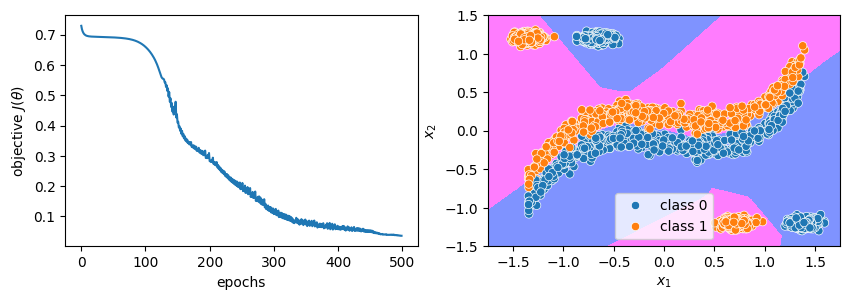

In [181]:
# define the loss function and optimizer
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD(params=parameters.values(), lr=5e-1)
running_objectives = []

# train the model
num_epochs = 500
for _ in range(num_epochs):
    optimizer.zero_grad()
    y_hat = phi(X, parameters)
    loss = loss_fn(y_hat.squeeze(), y)
    running_objectives.append(loss.detach().clone())
    loss.backward()
    optimizer.step()

_, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 3))

# define colormap for the contour plots
desat_blue = '#7F93FF'
desat_magenta = '#FF7CFE'
binary_cmap = clr.LinearSegmentedColormap.from_list(name='binary', colors=[desat_blue, desat_magenta], N=2)

# get the grid for the contour plot
resolution = 1000
x_1 = (-1.75, 1.75)
x_2 = (-1.5, 1.5)
x1_grid, x2_grid = torch.meshgrid(torch.linspace(*x_1, resolution), torch.linspace(*x_2, resolution))
grid = torch.column_stack((x1_grid.reshape((resolution ** 2, -1)), x2_grid.reshape((resolution ** 2, -1))))

# plot the objective function
axes[0].plot(range(len(running_objectives)), running_objectives)
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('objective $J(\\theta)$')

# apply the fitted model to the grid
z = model(X=grid, parameters=parameters)

# plot the decision boundary and colors
z = z.reshape(shape=(resolution, resolution))
axes[1].contourf(x1_grid, x2_grid, z, cmap=binary_cmap)
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_2$')

# plot the data
g = sns.scatterplot(data=df, x='x_1', y='x_2', hue='y', ax=axes[1])

# change the default seaborn legend
g.legend_.set_title(None)
new_labels = ['class 0', 'class 1']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

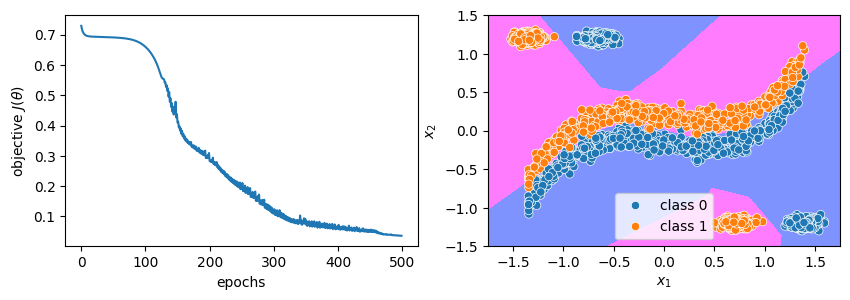

In [197]:
# define the loss function and optimizer
optimizer = torch.optim.SGD(params=parameters.values(), lr=5e-1)
running_objectives = []

# train the model
num_epochs = 500
for _ in range(num_epochs):
    optimizer.zero_grad()
    objective = J(X=X, y=y, parameters=parameters)
    running_objectives.append(objective.detach().clone())
    objective.backward()
    optimizer.step()

_, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 3))

# define colormap for the contour plots
desat_blue = '#7F93FF'
desat_magenta = '#FF7CFE'
binary_cmap = clr.LinearSegmentedColormap.from_list(name='binary', colors=[desat_blue, desat_magenta], N=2)

# get the grid for the contour plot
resolution = 1000
x_1 = (-1.75, 1.75)
x_2 = (-1.5, 1.5)
x1_grid, x2_grid = torch.meshgrid(torch.linspace(*x_1, resolution), torch.linspace(*x_2, resolution))
grid = torch.column_stack((x1_grid.reshape((resolution ** 2, -1)), x2_grid.reshape((resolution ** 2, -1))))

# plot the objective function
axes[0].plot(range(len(running_objectives)), running_objectives)
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('objective $J(\\theta)$')

# apply the fitted model to the grid
z = model(X=grid, parameters=parameters)

# plot the decision boundary and colors
z = z.reshape(shape=(resolution, resolution))
axes[1].contourf(x1_grid, x2_grid, z, cmap=binary_cmap)
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_2$')

# plot the data
g = sns.scatterplot(data=df, x='x_1', y='x_2', hue='y', ax=axes[1])

# change the default seaborn legend
g.legend_.set_title(None)
new_labels = ['class 0', 'class 1']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)